## Apresentação 

Notebook destinado à criação de um chatbot que apresenta a capacidade de realizar resumos - para diminuir a quantidade de tokens informados até um outro node para produzir a resposta final - e memória. Tais estratégias se relacionam a um contexto da otimização da criação de chatbots em termos de custo computacional e financeiro, além de prover melhor experiência do usuário e aplicações com IA generativa mais robustas. 

### Librarys 

In [5]:
import getpass
import os
import sqlite3

from dotenv import load_dotenv

from IPython.display import Image, display

from langchain_groq import ChatGroq

from langgraph.graph import (MessagesState, 
                             StateGraph,
                             START, 
                             END)

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver


from langchain_core.messages import (SystemMessage, 
                                     HumanMessage, 
                                     RemoveMessage)

### Variável de ambiente

In [24]:
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

### Modelo 

In [25]:
# Instanciando o modelo de LLM que será utilizado. 
llm = ChatGroq(
    model="llama-3.2-90b-text-preview",
    temperature=0.5,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [26]:
# Testando a conexão com a API. 
llm.invoke("BMTH é a sigla de qual banda ?").content

'BMTH é a sigla da banda "Bring Me the Horizon". É uma banda britânica de metalcore formada em 2004 em Sheffield, Inglaterra.'

### Criando o chatbot 

In [8]:
# Criando a classe State, que irá provisionar a persistência de dados
# nos nodes da arquitetura. A classe herda MessagesState, um reducer 
# que aplica por padrão a adição de mensagens num formato de lista, 
# e não a sua sobre-escrita. 

class State(MessagesState): 
    summary : str

In [9]:
def call_model(state : State):

    """Função que chama o modelo de LLM utilizado e implementa
       uma funcionalidade de resumo, visando diminuir os custos
       financeiros e processamento da resposta do modelo. """


    # Extração do resumo por meio da chave "summary". 
    # Caso não exista resumo algum, é retornado vazio. 
    summary = state.get("summary", "")

    if summary:

        # Instrução ao sistema. 
        system_message = f"Summary of conversation earlier: {summary}"

        # Armazena a instrução ao sistema e as mensagens existentes. 
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:

        # Se não existir resumo, apenas retorna as mensagens. 
        messages = state["messages"]

    # Resposta do modelo. 
    response = llm.invoke(messages)
    return {"messages": response}


In [10]:
def summarize_conversation(state: State):

    """Função que realiza uma conversa."""

    # Extração do resumo por meio da chave "summary". 
    # Caso não exista resumo algum, é retornado vazio.
    summary = state.get("summary", "")
    
    if summary:
        
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Adiciona o resumo junto das mensagens recebidas. 
    messages = state["messages"] + [HumanMessage(content=summary_message)]

    response = llm.invoke(messages)

    return {"summary": response.content, "messages": messages}

In [11]:
def should_continue(state : State):

    """Função que verifica a necessidade de realizar
       o resumo da conversa ou não."""

    messages = state["messages"]

    # Critério lógico que decide que acima de 5 mensagens
    # o modelo irá chamar a função que realiza o resumo. 
    if len(messages) > 5:
        return "summarize_conversation"
    
    return END

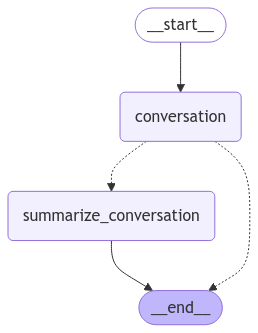

In [ ]:
# Construtor da arquitetura
workflow = StateGraph(State)

# Definindo os nodes presentes
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

# Definindo os entrypoints - por onde irá passar o fluxo. 
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue) # edge condicional que bifurca o fluxo.
workflow.add_edge("summarize_conversation", END)

# Definindo o checkpointer - criação de memória. 
memory = MemorySaver()
chatbot = workflow.compile(checkpointer=memory)

display(Image(chatbot.get_graph().draw_mermaid_png()))

In [49]:
# Criando a thread. 
config = {"configurable": {"thread_id": "10"}}

# Conversação. 
input_message = HumanMessage(content="hi! I'm Lance")
output = chatbot.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()



================================== Ai Message ==================================

Hi Lance, it's nice to meet you. Is there something I can help you with or would you like to chat?


In [50]:
input_message = HumanMessage(content="what's my name?")
output = chatbot.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()



================================== Ai Message ==================================

Your name is Lance.


In [51]:
input_message = HumanMessage(content="I like the BMTH!")
output = chatbot.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================ Human Message =================================

Create a summary of the conversation above:


In [52]:
# Verificando o resumo.
chatbot.get_state(config).values.get("summary","")

"Here's a summary of our conversation:\n\nWe had a casual conversation where you introduced yourself as Lance. You then mentioned that you like the band Bring Me The Horizon (BMTH). I responded by acknowledging your interest in the band and briefly mentioning their evolution in sound over the years."

In [53]:
input_message = HumanMessage(content="I like the Poppy too, and you ?")
output = chatbot.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================ Human Message =================================

This is summary of the conversation to date: Here's a summary of our conversation:

We had a casual conversation where you introduced yourself as Lance. You then mentioned that you like the band Bring Me The Horizon (BMTH). I responded by acknowledging your interest in the band and briefly mentioning their evolution in sound over the years.

Extend the summary by taking into account the new messages above:


### Utilizando memória externa

In [19]:
conect = sqlite3.connect(":memory:", check_same_thread=False)

In [20]:
db_path = "state_db/example.db"
conect = sqlite3.connect(":memory:", check_same_thread=False)

In [21]:
external_memory = SqliteSaver(conect)

In [15]:
# Criando a classe State, que irá provisionar a persistência de dados
# nos nodes da arquitetura. A classe herda MessagesState, um reducer 
# que aplica por padrão a adição de mensagens num formato de lista, 
# e não a sua sobre-escrita. 

class State(MessagesState): 
    summary : str



In [16]:
def call_model(state : State):

    """Função que chama o modelo de LLM utilizado e implementa
       uma funcionalidade de resumo, visando diminuir os custos
       financeiros e processamento da resposta do modelo. """


    # Extração do resumo por meio da chave "summary". 
    # Caso não exista resumo algum, é retornado vazio. 
    summary = state.get("summary", "")

    if summary:

        # Instrução ao sistema. 
        system_message = f"Summary of conversation earlier: {summary}"

        # Armazena a instrução ao sistema e as mensagens existentes. 
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:

        # Se não existir resumo, apenas retorna as mensagens. 
        messages = state["messages"]

    # Resposta do modelo. 
    response = llm.invoke(messages)
    return {"messages": response}


In [17]:
def summarize_conversation(state: State):

    """Função que realiza uma conversa."""

    # Extração do resumo por meio da chave "summary". 
    # Caso não exista resumo algum, é retornado vazio.
    summary = state.get("summary", "")
    
    if summary:
        
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Adiciona o resumo junto das mensagens recebidas. 
    messages = state["messages"] + [HumanMessage(content=summary_message)]

    response = llm.invoke(messages)

    return {"summary": response.content, "messages": messages}

In [18]:
def should_continue(state : State):

    """Função que verifica a necessidade de realizar
       o resumo da conversa ou não."""

    messages = state["messages"]

    # Critério lógico que decide que acima de 5 mensagens
    # o modelo irá chamar a função que realiza o resumo. 
    if len(messages) > 5:
        return "summarize_conversation"
    
    return END

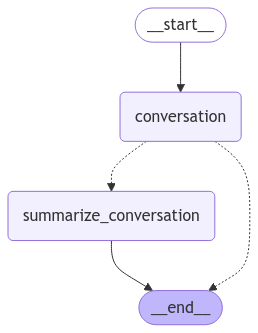

In [22]:
# Construtor da arquitetura
workflow = StateGraph(State)

# Definindo os nodes presentes
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

# Definindo os entrypoints - por onde irá passar o fluxo. 
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue) # edge condicional que bifurca o fluxo.
workflow.add_edge("summarize_conversation", END)

# Definindo o checkpointer - criação de memória. 
memory = MemorySaver()
chatbot = workflow.compile(checkpointer=external_memory)

display(Image(chatbot.get_graph().draw_mermaid_png()))

In [27]:
# Criando a thread. 
config = {"configurable": {"thread_id": "15"}}

# Conversação. 
input_message = HumanMessage(content="hi! I'm Noctis")
output = chatbot.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()



================================== Ai Message ==================================

Hello Noctis.  It seems like you're referring to Noctis Lucis Caelum, the main character from the popular video game "Final Fantasy XV".  What's on your mind, Noctis?


In [28]:
# Criando a thread. 
config = {"configurable": {"thread_id": "15"}}

# Conversação. 
input_message = HumanMessage(content="So, you know me ? If you do, could say my last name please ?")
output = chatbot.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()



================================== Ai Message ==================================

As Noctis Lucis Caelum, your last name is indeed "Caelum" and also "Lucis" as it's a part of your full name and title as the Crown Prince of the kingdom of Lucis.


In [29]:
# Criando a thread. 
config = {"configurable": {"thread_id": "15"}}

# Conversação. 
input_message = HumanMessage(content="What was the last question I asked ?")
output = chatbot.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()



================================ Human Message =================================

Create a summary of the conversation above:


In [30]:
# Verificando o resumo.
chatbot.get_state(config).values.get("summary","")

'Here\'s a summary of our conversation:\n\n* You introduced yourself as Noctis.\n* I recognized you as Noctis Lucis Caelum, the main character from the video game "Final Fantasy XV".\n* You asked if I knew you and if I could say your last name.\n* I replied that your last name is indeed "Caelum" and also "Lucis" as it\'s a part of your full name and title as the Crown Prince of the kingdom of Lucis.\n* You asked what your last question was.\n* I replied that your last question was about me knowing you and saying your last name.'

In [31]:
# Confirmando se o estado está sendo persistido

config = {"configurable": {"thread_id": "15"}}
graph_state = chatbot.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Noctis", additional_kwargs={}, response_metadata={}, id='17470f0b-c36b-4492-b9a0-75b58f9fa771'), HumanMessage(content="hi! I'm Noctis", additional_kwargs={}, response_metadata={}, id='02da909f-4817-4751-8e22-9c7187715182'), AIMessage(content='Hello Noctis.  It seems like you\'re referring to Noctis Lucis Caelum, the main character from the popular video game "Final Fantasy XV".  What\'s on your mind, Noctis?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 54, 'total_tokens': 101, 'completion_time': 0.188, 'prompt_time': 0.010040446, 'queue_time': 0.0035809329999999997, 'total_time': 0.198040446}, 'model_name': 'llama-3.2-90b-text-preview', 'system_fingerprint': 'fp_5c5d1b5cfb', 'finish_reason': 'stop', 'logprobs': None}, id='run-e17a446f-098b-4b47-b835-c6ab94d85bb5-0', usage_metadata={'input_tokens': 54, 'output_tokens': 47, 'total_tokens': 101}), HumanMessage(content='